# Supervised sentiment: dense feature representations and neural networks

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Fall 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Distributed representations as features](#Distributed-representations-as-features)
  1. [GloVe inputs](#GloVe-inputs)
  1. [IMDB representations](#IMDB-representations)
  1. [Remarks on this approach](#Remarks-on-this-approach)
1. [RNN classifiers](#RNN-classifiers)
  1. [RNN dataset preparation](#RNN-dataset-preparation)
  1. [Vocabulary for the embedding](#Vocabulary-for-the-embedding)
  1. [PyTorch RNN classifier](#PyTorch-RNN-classifier)
  1. [Pretrained embeddings](#Pretrained-embeddings)
  1. [RNN hyperparameter tuning experiment](#RNN-hyperparameter-tuning-experiment)
1. [The VecAvg baseline from Socher et al. 2013](#The-VecAvg-baseline-from-Socher-et-al.-2013)
  1. [Defining the model](#Defining-the-model)
  1. [VecAvg hyperparameter tuning experiment](#VecAvg-hyperparameter-tuning-experiment)
1. [Tree-structured neural networks](#Tree-structured-neural-networks)
  1. [TreeNN dataset preparation](#TreeNN-dataset-preparation)
  1. [PyTorch TreeNN](#PyTorch-TreeNN)
  1. [Subtree supervision](#Subtree-supervision)

## Overview

This notebook defines and explores __vector averaging__, __recurrent neural network (RNN) classifiers__ and __tree-structured neural network (TreeNN) classifiers__ for the Stanford Sentiment Treebank. 

These approaches make their predictions based on comprehensive representations of the examples: 

* For the vector averaging models, each word is modeled, but we assume that words combine via a simple function that is insensitive to their order or constituent structure.
* For the RNN, each word is again modeled, and we also model the sequential relationships between words.
* For the TreeNN, the entire parsed structure of the sentence is modeled.

All these models contrast with the ones explored in [the previous notebook](sst_02_hand_built_features.ipynb), which make predictions based on more partial, potentially idiosyncratic information extracted from the examples.

## Set-up

See [the first notebook in this unit](sst_01_overview.ipynb#Set-up) for set-up instructions.

In [2]:
from collections import Counter
import numpy as np
import os
import pandas as pd
from np_rnn_classifier import RNNClassifier
from np_tree_nn import TreeNN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import sst
import vsm
import utils

In [3]:
utils.fix_random_seeds()

In [4]:
DATA_HOME = '/Users/pierrejaumier/Data/cs224u'
SST_HOME = os.path.join(DATA_HOME, 'trees')

In [5]:
#DATA_HOME = 'data'

GLOVE_HOME = os.path.join(DATA_HOME, 'glove.6B')

VSMDATA_HOME = os.path.join(DATA_HOME, 'vsmdata')

SST_HOME = os.path.join(DATA_HOME, 'trees')

## Distributed representations as features

As a first step in the direction of neural networks for sentiment, we can connect with our previous unit on distributed representations. Arguably, more than any specific model architecture, this is the major innovation of deep learning: __rather than designing feature functions by hand, we use dense, distributed representations, often derived from unsupervised models__.

<img src="fig/distreps-as-features.png" width=500 alt="distreps-as-features.png" />

Our model will just be `LogisticRegression`, and we'll continue with the experiment framework from the previous notebook. Here is `fit_maxent_classifier` again:

In [6]:
def fit_maxent_classifier(X, y):
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='auto')
    mod.fit(X, y)
    return mod

### GloVe inputs

To illustrate this process, we'll use the general purpose GloVe representations released by the GloVe team, at 300d:

In [7]:
glove_lookup = utils.glove2dict(
    os.path.join(GLOVE_HOME, 'glove.6B.300d.txt'))

In [8]:
#glove_lookup['test']

In [9]:
def vsm_leaves_phi(tree, lookup, np_func=np.mean):
    """Represent `tree` as a combination of the vector of its words.

    Parameters
    ----------
    tree : nltk.Tree

    lookup : dict
        From words to vectors.

    np_func : function (default: np.mean)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a
        fixed length, no matter what the size of the tree is.

    Returns
    -------
    np.array, dimension `X.shape[1]`

    """
    allvecs = np.array([lookup[w] for w in tree.leaves() if w in lookup])
    if len(allvecs) == 0:
        dim = len(next(iter(lookup.values())))
        feats = np.zeros(dim)
    else:
        feats = np_func(allvecs, axis=0)
    return feats

In [10]:
def glove_leaves_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, glove_lookup, np_func=np_func)

In [11]:
%%time
_ = sst.experiment(
    SST_HOME,
    glove_leaves_phi,
    fit_maxent_classifier,
    vectorize=False)  # Tell `experiment` that we already have our feature vectors.

              precision    recall  f1-score   support

    negative      0.746     0.789     0.767       941
    positive      0.816     0.778     0.797      1135

    accuracy                          0.783      2076
   macro avg      0.781     0.783     0.782      2076
weighted avg      0.785     0.783     0.783      2076

CPU times: user 2.92 s, sys: 183 ms, total: 3.1 s
Wall time: 3.17 s


### IMDB representations

Our IMDB VSMs seems pretty well-attuned to the Stanford Sentiment Treebank, so we might think that they can do even better than the general-purpose GloVe inputs. Here are two quick assessments of that idea that seeks to build on ideas we developed in the unit on VSMs.

In [12]:
imdb20 = pd.read_csv(
    os.path.join(VSMDATA_HOME, 'imdb_window20-flat.csv.gz'), index_col=0)

In [13]:
imdb20_ppmi = vsm.pmi(imdb20, positive=False)

In [14]:
imdb20_ppmi_svd = vsm.lsa(imdb20_ppmi, k=300)

In [15]:
imdb_lookup = dict(zip(imdb20_ppmi_svd.index, imdb20_ppmi_svd.values))

In [16]:
def imdb_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, imdb_lookup, np_func=np_func)

In [17]:
%%time
_ = sst.experiment(
    SST_HOME,
    imdb_phi,
    fit_maxent_classifier,
    vectorize=False)  # Tell `experiment` that we already have our feature vectors.

              precision    recall  f1-score   support

    negative      0.746     0.733     0.739       977
    positive      0.766     0.778     0.772      1099

    accuracy                          0.757      2076
   macro avg      0.756     0.755     0.756      2076
weighted avg      0.757     0.757     0.757      2076

CPU times: user 2.76 s, sys: 176 ms, total: 2.93 s
Wall time: 2.74 s


### Remarks on this approach

* Recall that our `unigrams_phi` created feature representations with over 16K dimensions and got about 0.77 with no hyperparameter tuning.

* The above models' feature representations have only 300 dimensions, and they are about the same. In many ways, it's striking that we can get a model that is competitive with so few dimensions.

* The promise of the Mittens model of [Dingwall and Potts 2018](https://arxiv.org/abs/1803.09901) is that we can use GloVe itself to update the general purpose information in the 'glove.6B' vectors with specialized information from one of these IMDB count matrices. That might be worth trying; the `mittens` package (`pip install mittens`) already implements this!

* That said, just summing up all the word representations is pretty unappealing linguistically. There's no doubt that we're losing a lot of valuable information in doing this. The models we turn to now can be seen as addressing this shortcoming while retaining the insight that our distributed representations are valuable for this task.

* We'll return to these ideas below, when we consider [the VecAvg baseline from Socher et al. 2013](#The-VecAvg-baseline-from-Socher-et-al.-2013). That model also posits a simple, fixed combination function (averaging). However, it begins with randomly initialized representations and updates them as part of training.

## RNN classifiers

A recurrent neural network (RNN) is any deep learning model that process its inputs sequentially. There are many variations on this theme. The one that we use here is an __RNN classifier__.

<img src="fig/rnn_classifier.png" width=800 />

The version of the model that is implemented in `np_rnn_classifier.py` corresponds exactly to the above diagram. We can express it mathematically as follows:

$$\begin{align*}
h_{t} &= \tanh(x_{t}W_{xh} + h_{t-1}W_{hh}) \\
y     &= \textbf{softmax}(h_{n}W_{hy} + b_y)
\end{align*}$$

where $1 \leqslant t \leqslant n$. The first line defines the recurrence: each hidden state $h_{t}$ is defined by the input $x_{t}$ and the previous hidden state $h_{t-1}$, together with weight matrices $W_{xh}$ and $W_{hh}$, which are used at all timesteps. As indicated in the above diagram, the sequence of hidden states is padded with an initial state $h_{0}$. In our implementations, this is always an all $0$ vector, but it can be initialized in more sophisticated ways (some of which we will explore in our units on natural language inference and grounded natural language generation).

The model in `torch_rnn_classifier.py` expands on the above and allows for more flexibility:

$$\begin{align*}
h_{t} &= \text{RNN}(x_{t}, h_{t-1}) \\
h     &= f(h_{n}W_{hh} + b_{h}) \\
y     &= \textbf{softmax}(hW_{hy} + b_y)
\end{align*}$$

Here, $\text{RNN}$ stands for all the parameters of the recurrent part of the model. This will depend on the choice one makes for `rnn_cell_class`; options include `nn.RNN`, `nn.LSTM`, and `nn.GRU`. In addition, the classifier part includes a hidden layer (middle row), and the user can decide on the activation funtion $f$ to use there (parameter: `classifier_activation`).

This is a potential gain over our average-vectors baseline, in that it processes each word independently, and in the context of those that came before it. Thus, not only is this sensitive to word order, but the hidden representation create the potential to encode how the preceding context for a word affects its interpretation.

The downside of this, of course, is that this model is much more difficult to set up and optimize. Let's dive into those details.

### RNN dataset preparation

SST contains trees, but the RNN processes just the sequence of leaf nodes. The function `sst.build_rnn_dataset` creates datasets in this format:

In [20]:
X_rnn_train, y_rnn_train = sst.build_rnn_dataset(
    SST_HOME, sst.train_reader, class_func=sst.binary_class_func)

Each member of `X_rnn_train` is a list of lists of words. Here's a look at the start of the first:

In [23]:
X_rnn_train[0][: 6]

['The', 'Rock', 'is', 'destined', 'to', 'be']

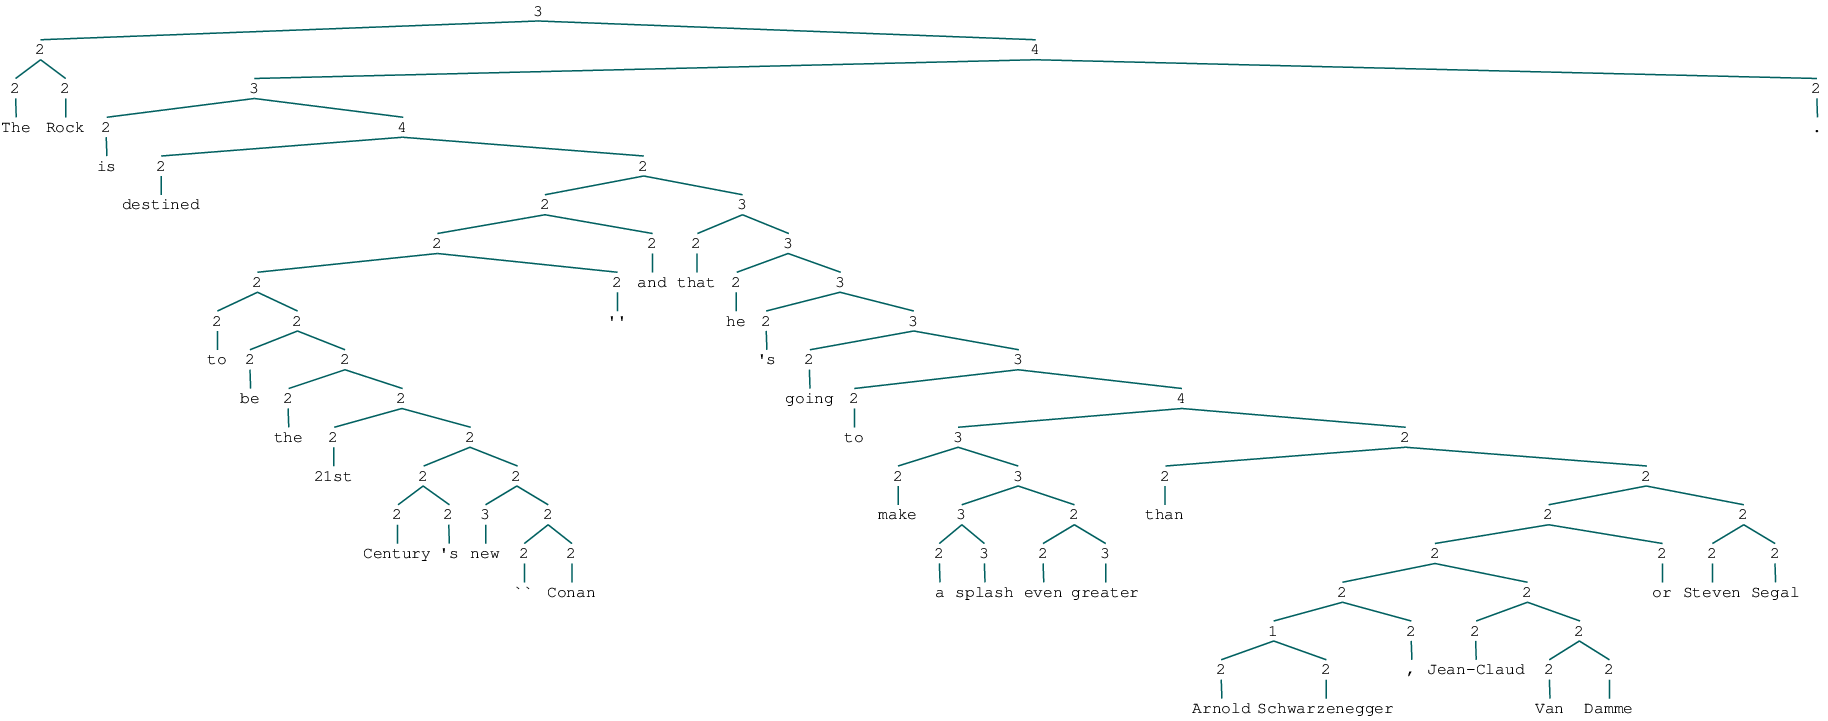

In [19]:
# Pour rappel: données initiales
tree, score = next(sst.train_reader(SST_HOME))
tree

Because this is a classifier, `y_rnn_train` is just a list of labels, one per example:

In [24]:
y_rnn_train[0]

'positive'

For experiments, let's build a `dev` dataset as well:

In [25]:
X_rnn_dev, y_rnn_dev = sst.build_rnn_dataset(
    SST_HOME, sst.dev_reader, class_func=sst.binary_class_func)

### Vocabulary for the embedding

The first delicate issue we need to address is the vocabulary for our model:

* As indicated in the figure above, the first thing we do when processing an example is look up the words in an embedding (a VSM), which has to have a fixed dimensionality. 

* We can use our training data to specify the vocabulary for this embedding; at prediction time, though, we will inevitably encounter words we haven't seen before. 

* The convention we adopt here is to map them to an `$UNK` token that is in our pre-specified vocabulary.

* At the same time, we might want to collapse infrequent tokens into `$UNK` to make optimization easier and to try to create reasonable representations for words that we have to map to `$UNK` at test time.

In `utils`, the function `get_vocab` will help you specify a vocabulary. It will let you choose a vocabulary by optionally specifying `mincount` or `n_words`, and it will ensure that `$UNK` is included.

In [26]:
sst_full_train_vocab = utils.get_vocab(X_rnn_train)

In [27]:
print("sst_full_train_vocab has {:,} items".format(len(sst_full_train_vocab)))

sst_full_train_vocab has 16,283 items


This frankly seems too big relative to our dataset size. Let's restrict to just words that occur at least twice:

In [28]:
sst_train_vocab = utils.get_vocab(X_rnn_train, mincount=2)

In [29]:
print("sst_train_vocab has {:,} items".format(len(sst_train_vocab)))

sst_train_vocab has 7,564 items


### PyTorch RNN classifier

Here and throughout, we'll rely on `early_stopping=True` to try to find the optimal time to stop optimization. This behavior can be further refined by setting different values of `validation_fraction`, `n_iter_no_change`, and `tol`. For additional discussion, see [the section on model convergence in the evaluation methods notebook](#Assessing-models-without-convergence).

In [30]:
rnn = TorchRNNClassifier(
    sst_train_vocab,
    early_stopping=True)

In [31]:
%time _ = rnn.fit(X_rnn_train, y_rnn_train)

Stopping after epoch 52. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.14809725293889642

CPU times: user 4min 46s, sys: 1min 1s, total: 5min 48s
Wall time: 2min 59s


In [32]:
rnn_dev_preds = rnn.predict(X_rnn_dev)

In [33]:
print(classification_report(y_rnn_dev, rnn_dev_preds, digits=3))

              precision    recall  f1-score   support

    negative      0.712     0.745     0.728       428
    positive      0.743     0.709     0.726       444

    accuracy                          0.727       872
   macro avg      0.727     0.727     0.727       872
weighted avg      0.728     0.727     0.727       872



The above numbers are just a starting point. Let's try to improve on them by using pretrained embeddings and then by exploring a range of hyperparameter options.

### Pretrained embeddings

With `embedding=None`, `TorchRNNClassifier` (and its counterpart in `np_rnn_classifier.py`) create random embeddings. You can also pass in an embedding, as long as you make sure it has the right vocabulary. The utility `utils.create_pretrained_embedding` will help with that:

In [28]:
glove_embedding, sst_glove_vocab = utils.create_pretrained_embedding(
    glove_lookup, sst_train_vocab)

Here's an illustration using `TorchRNNClassifier`:

In [29]:
rnn_glove = TorchRNNClassifier(
    sst_glove_vocab,
    embedding=glove_embedding,
    early_stopping=True)

In [30]:
%time _ = rnn_glove.fit(X_rnn_train, y_rnn_train)

Stopping after epoch 23. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.12253877334296703

CPU times: user 15 s, sys: 14.7 ms, total: 15 s
Wall time: 2.74 s


In [31]:
rnn_glove_dev_preds = rnn_glove.predict(X_rnn_dev)

In [32]:
print(classification_report(y_rnn_dev, rnn_glove_dev_preds, digits=3))

              precision    recall  f1-score   support

    negative      0.824     0.724     0.771       428
    positive      0.762     0.851     0.804       444

    accuracy                          0.789       872
   macro avg      0.793     0.788     0.788       872
weighted avg      0.793     0.789     0.788       872



It looks like pretrained representations give us a notable boost, but we're still below most of the simpler models explored in [the previous notebook](sst_02_hand_built_features.ipynb).

### RNN hyperparameter tuning experiment

As we saw in [the previous notebook](sst_02_hand_built_features.ipynb), we're not really done until we've done some hyperparameter search. So let's round out this section by cross-validating the RNN that uses GloVe embeddings, to see if we can improve on the default-parameters model we evaluated just above. For this, we'll use `sst.experiment`:

In [33]:
def simple_leaves_phi(tree):
    return tree.leaves()

In [34]:
def fit_rnn_with_hyperparameter_search(X, y):
    basemod = TorchRNNClassifier(
        sst_train_vocab,
        embedding=glove_embedding,
        batch_size=25,  # Inspired by comments in the paper.
        bidirectional=True,
        early_stopping=True)

    # There are lots of other parameters and values we could
    # explore, but this is at least a solid start:
    param_grid = {
        'embed_dim': [25, 50, 75, 100],
        'hidden_dim': [25, 50, 75, 100],
        'eta': [0.001, 0.01, 0.05]}

    bestmod = utils.fit_classifier_with_hyperparameter_search(
        X, y, basemod, cv=3, param_grid=param_grid)

    return bestmod

In [35]:
%%time
rnn_experiment_xval = sst.experiment(
    SST_HOME,
    simple_leaves_phi,
    fit_rnn_with_hyperparameter_search,
    vectorize=False)

Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 3.154094541274389555

Best params: {'embed_dim': 75, 'eta': 0.001, 'hidden_dim': 75}
Best score: 0.791
              precision    recall  f1-score   support

    negative      0.769     0.834     0.800      1002
    positive      0.832     0.766     0.798      1074

    accuracy                          0.799      2076
   macro avg      0.801     0.800     0.799      2076
weighted avg      0.802     0.799     0.799      2076

CPU times: user 34min 15s, sys: 15.6 s, total: 34min 30s
Wall time: 34min 16s


Here we carry forward the optimal model from our hyperparameter search, to run a final assessment on the test set:

In [36]:
def fit_optimized_rnn(X, y):
    mod = rnn_experiment_xval['model']
    mod.fit(X, y)
    return mod

In [37]:
%%time
_ = sst.experiment(
    SST_HOME,
    simple_leaves_phi,
    fit_optimized_rnn,
    class_func=sst.binary_class_func,
    train_reader=(sst.train_reader, sst.dev_reader),
    assess_reader=sst.test_reader,
    vectorize=False)

Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 2.3395959859716413

              precision    recall  f1-score   support

    negative      0.815     0.826     0.820       912
    positive      0.823     0.812     0.817       909

    accuracy                          0.819      1821
   macro avg      0.819     0.819     0.819      1821
weighted avg      0.819     0.819     0.819      1821

CPU times: user 21.4 s, sys: 102 ms, total: 21.5 s
Wall time: 21.4 s


This model looks quite competitive with the simpler models we explored previously, and perhaps an even wider hyperparameter search would lead to additional improvements. In [contextualreps.ipynb](contextualreps.ipynb), we look at variants of the above that involve fine-tuning with ELMo and BERT, and those models achieve results around 0.90 on the test set, which further highlights the value of rich pretraining.

## The VecAvg baseline from Socher et al. 2013

One of the baseline models from [Socher et al., Table 1](http://www.aclweb.org/anthology/D/D13/D13-1170.pdf) is __VecAvg__. This is like the model we explored above under the heading of [Distributed representations as features](#Distributed-representations-as-features), but it uses a random initial embedding that is updated as part of optimization. Another perspective on it is that it is like the RNN we just evaluated, but with the RNN parameters replaced by averaging. 

In Socher et al. 2013, this model does reasonably well, scoring 80.1 on the root-only binary problem. In this section, we reimplement it, relying on `TorchRNNClassifier` to handle most of the heavy-lifting, and we evaluate it with a reasonably wide hyperparameter search.

### Defining the model

The core model is `TorchVecAvgModel`, which just looks up embeddings, averages them, and feeds the result to a classifier layer:

In [38]:
class TorchVecAvgModel(nn.Module):
    def __init__(self, vocab_size, output_dim, device, embed_dim=50):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.output_dim = output_dim
        self.device = device
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        self.classifier_layer = nn.Linear(self.embed_dim, self.output_dim)

    def forward(self, X, seq_lengths):
        embs = self.embedding(X)
        # Mask based on the **true** lengths:
        mask = [torch.ones(l, self.embed_dim) for l in seq_lengths]
        mask = torch.nn.utils.rnn.pad_sequence(mask, batch_first=True)
        mask = mask.to(self.device)
        # True average:
        mu = (embs * mask).sum(axis=1) / seq_lengths.unsqueeze(1)
        # Classifier:
        logits = self.classifier_layer(mu)
        return logits

For the main interface, we can just subclass `TorchRNNClassifier` and change the `build_graph` method to use `TorchVecAvgModel`. (For more details on the code and logic here, see the notebook [tutorial_torch_models.ipynb](tutorial_torch_models.ipynb).)

In [39]:
class TorchVecAvgClassifier(TorchRNNClassifier):

    def build_graph(self):
        return TorchVecAvgModel(
            vocab_size=len(self.vocab),
            output_dim=self.n_classes_,
            device=self.device,
            embed_dim=self.embed_dim)

### VecAvg hyperparameter tuning experiment

Now that we have the model implemented, let's see if we can reproduce Socher et al.'s 80.1 on the binary, root-only version of SST.

First, we do the hyperparameter search:

In [40]:
def fit_vecavg_with_hyperparameter_search(X, y):
    basemod = TorchVecAvgClassifier(
        sst_train_vocab,
        early_stopping=True)

    param_grid = {
        'embed_dim': [50, 100, 200, 300],
        'eta': [0.001, 0.01, 0.05]}

    bestmod = utils.fit_classifier_with_hyperparameter_search(
        X, y, basemod, cv=3, param_grid=param_grid)

    return bestmod

In [41]:
%%time
vecavg_experiment_xval = sst.experiment(
    SST_HOME,
    simple_leaves_phi,
    fit_vecavg_with_hyperparameter_search,
    vectorize=False)

Stopping after epoch 18. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.080092592164874088

Best params: {'embed_dim': 300, 'eta': 0.01}
Best score: 0.766
              precision    recall  f1-score   support

    negative      0.786     0.715     0.749      1011
    positive      0.751     0.815     0.782      1065

    accuracy                          0.766      2076
   macro avg      0.768     0.765     0.765      2076
weighted avg      0.768     0.766     0.766      2076

CPU times: user 16min 49s, sys: 23.2 s, total: 17min 13s
Wall time: 4min 47s


And then we use the best parameters found above to train a new model on the union of the train and dev sets:

In [42]:
def fit_optimized_vecavg(X, y):
    mod = vecavg_experiment_xval['model']
    mod.fit(X, y)
    return mod

In [43]:
%%time
_= sst.experiment(
    SST_HOME,
    simple_leaves_phi,
    fit_optimized_vecavg,
    class_func=sst.binary_class_func,
    train_reader=(sst.train_reader, sst.dev_reader),
    assess_reader=sst.test_reader,
    vectorize=False)

Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.14763524942100048

              precision    recall  f1-score   support

    negative      0.798     0.823     0.811       912
    positive      0.817     0.791     0.804       909

    accuracy                          0.807      1821
   macro avg      0.808     0.807     0.807      1821
weighted avg      0.808     0.807     0.807      1821

CPU times: user 29.5 s, sys: 2.14 s, total: 31.6 s
Wall time: 9.93 s


Excellent – it looks like we basically reproduced the number from the paper (80.1).

## Tree-structured neural networks

Tree-structured neural networks (TreeNNs) are close relatives of RNN classifiers. (If you tilt your head, you can see the above sequence model as a kind of tree.) The TreeNNs we explore here are the simplest possible and actually have many fewer parameters than RNNs. Here's a summary:

<img src="fig/tree_nn.png" width=800 />

The crucial property of these networks is the way they employ recursion: the representation of a parent node $p$ has the same dimensionality as the word representations, allowing seamless repeated application of the central combination function:

$$p = \tanh([x_{L};x_{R}]W_{wh} + b)$$

Here, $[x_{L};x_{R}]$ is the concatenation of the left and right child representations, and $p$ is the resulting parent node, which can then be a child node in a higher subtree.

When we reach the root node $h_{r}$ of the tree, we apply a softmax classifier using that top node's representation:

$$y = \textbf{softmax}(h_{r}W_{hy} + b)$$

### TreeNN dataset preparation

This is the only model under consideration here that makes use of the tree structures in the SST:

In [44]:
X_tree_train, y_tree_train = sst.build_tree_dataset(
    SST_HOME, sst.train_reader, class_func=sst.binary_class_func)

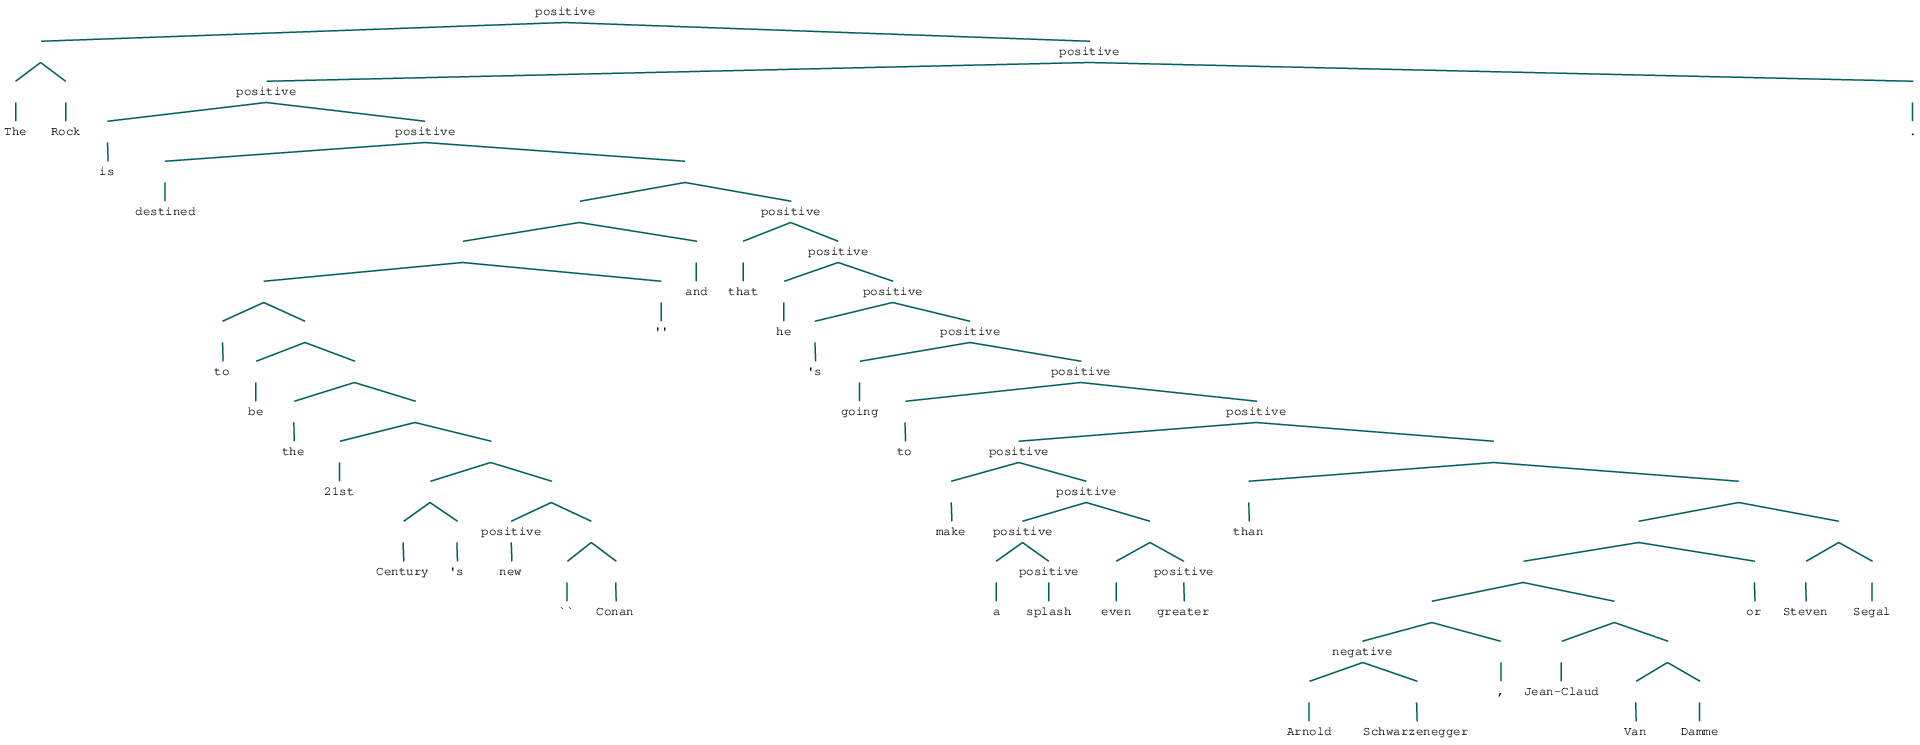

In [45]:
X_tree_train[0]

In [46]:
X_tree_dev, y_tree_dev = sst.build_tree_dataset(
    SST_HOME, sst.dev_reader, class_func=sst.binary_class_func)

### PyTorch TreeNN

In [47]:
torch_tree_nn_glove = TorchTreeNN(
    sst_glove_vocab,
    embedding=glove_embedding,
    max_grad_norm=10.0,
    early_stopping=True)

In [48]:
%time _ = torch_tree_nn_glove.fit(X_tree_train, y_tree_train)

Stopping after epoch 33. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 4.148158252239227

CPU times: user 26min 57s, sys: 175 ms, total: 26min 57s
Wall time: 26min 41s


In [49]:
tree_dev_preds = torch_tree_nn_glove.predict(X_tree_dev)

In [50]:
print(classification_report(y_tree_dev, tree_dev_preds, digits=3))

              precision    recall  f1-score   support

    negative      0.574     0.605     0.589       428
    positive      0.599     0.568     0.583       444

    accuracy                          0.586       872
   macro avg      0.586     0.586     0.586       872
weighted avg      0.587     0.586     0.586       872



### Subtree supervision

We've so far ignored one of the most exciting aspects of the SST: it has sentiment labels on every constituent from the root down to the lexical nodes. 

It is fairly easy to extend `TorchTreeNN` to learn from these additional labels. The key change is that the recursive interpretation function has to gather all of the node representations and their true labels and pass these to the loss function:

<img src="fig/tree_nn_subtrees.png" width=600 />